<a href="https://colab.research.google.com/github/lorenzophys/deep-learning-playground/blob/main/MNIST_digit_CNN_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MNIST digit CNN experiments

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from scipy.stats import norm

Loading the data from Keras.

In [ ]:
(train_images, train_labels), (test_images, test_labels) = keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


Check the shapes of the images.

In [ ]:
print('Train', train_images.shape, train_labels.shape)
print('Test', test_images.shape, test_labels.shape)

Train (60000, 28, 28) (60000,)
Test (10000, 28, 28) (10000,)


The images must be reshaped before being fed into the convolutional layer.

In [ ]:
train_images = train_images.reshape(-1,28,28,1)
test_images = test_images.reshape(-1,28,28,1)

print('Train', train_images.shape, train_labels.shape)
print('Test', test_images.shape, test_labels.shape)

Train (60000, 28, 28, 1) (60000,)
Test (10000, 28, 28, 1) (10000,)


Normalization. Normally you should check, but I already know that the pixels range from 0 to 255.

In [ ]:
train_images, test_images = train_images/255., test_images/255.

I want to try different architectures to see which one gets the best accuracy. I will start by choosing the number of Convolution+Pooling layers. I stop with three because the fourth would reduce the size of the input too much.

In [ ]:
names = ["CPx1","CPx2", "CPx3"]
nets = len(names)
model = [0] * nets
history = [0] * nets
epochs = 30

In [ ]:
for i in range(nets):
  model[i] = keras.models.Sequential()
  model[i].add(keras.layers.Conv2D(filters=16, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
  model[i].add(keras.layers.MaxPool2D())
  if i>0:
    model[i].add(keras.layers.Conv2D(filters=32, kernel_size=5, padding="same", activation="relu"))
    model[i].add(keras.layers.MaxPool2D())
  if i>1:
    model[i].add(keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"))
    model[i].add(keras.layers.MaxPool2D())
  model[i].add(keras.layers.Flatten())
  model[i].add(keras.layers.Dense(256, activation='relu'))
  model[i].add(keras.layers.Dense(10, activation='softmax'))
  model[i].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

For all the models I used the standard approach: adam optimizer, the sparse categorical crossentropy loss function, the relu activation for the first layers and the softmax for the output layer to encode probablility. The number of filters will be adjusted later. After the convolutions we have a dense layer with 256 neurons: this is the number that gave the best results for the same dataset, see the other notebook. For every model I want to check what's the maximum value of the accuracy on the training and validation set.

In [ ]:
for i in range(nets):
  history[i] = model[i].fit(train_images, train_labels,
                            epochs=epochs,
                            validation_data=(test_images, test_labels),
                            verbose=0)
  print(f"Type = {names[i]}, Max train accuracy = {np.max(history[i].history['accuracy']):.5f}, Max val accuracy = {np.max(history[i].history['val_accuracy']):.5f}")

Type = CPx1, Max train accuracy = 0.99958, Max val accuracy = 0.99040
Type = CPx2, Max train accuracy = 0.99955, Max val accuracy = 0.99270
Type = CPx3, Max train accuracy = 0.99885, Max val accuracy = 0.99420


There is little to no difference between two or three CP layers. I choose to go with CPx2.

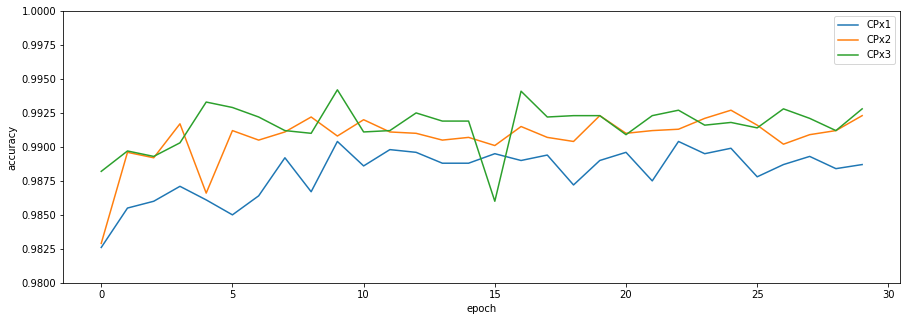

In [ ]:
plt.figure(figsize=(15,5))
for i in range(nets):
  plt.plot(history[i].history["val_accuracy"])

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names)
plt.gca().set_ylim([0.98,1])
plt.show()

For the second experiment I want to determine the best combination of filters. I try different powers of two.

In [ ]:
names_2 = ["8-16", "16-32", "32-64", "64-128"]
nets_2 = len(names_2)
model_2 = [0] * nets_2
history_2 = [0] * nets_2
epochs_2 = 20

In [ ]:
for i in range(nets_2):
  model_2[i] = keras.models.Sequential()
  model_2[i].add(keras.layers.Conv2D(filters=2**(i+3), kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
  model_2[i].add(keras.layers.MaxPool2D())
  model_2[i].add(keras.layers.Conv2D(filters=2**(i+4), kernel_size=5, padding="same", activation="relu"))
  model_2[i].add(keras.layers.MaxPool2D())
  model_2[i].add(keras.layers.Flatten())
  model_2[i].add(keras.layers.Dense(256, activation='relu'))
  model_2[i].add(keras.layers.Dense(10, activation='softmax'))
  model_2[i].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
for i in range(nets_2):
  history_2[i] = model_2[i].fit(train_images, train_labels,
                            epochs=epochs_2,
                            validation_data=(test_images, test_labels),
                            verbose=0)
  print(f"Type = {names_2[i]}, Max train accuracy = {np.max(history_2[i].history['accuracy']):.5f}, Max val accuracy = {np.max(history_2[i].history['val_accuracy']):.5f}")

Type = 8-16, Max train accuracy = 0.99878, Max val accuracy = 0.99190
Type = 16-32, Max train accuracy = 0.99913, Max val accuracy = 0.99260
Type = 32-64, Max train accuracy = 0.99937, Max val accuracy = 0.99390
Type = 64-128, Max train accuracy = 0.99902, Max val accuracy = 0.99330


The combination 32-64 is the best one.

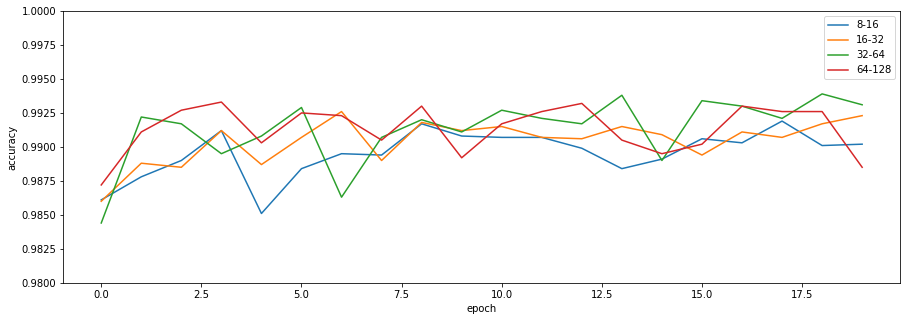

In [ ]:
plt.figure(figsize=(15,5))
for i in range(nets_2):
  plt.plot(history_2[i].history["val_accuracy"])

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names_2)
plt.gca().set_ylim([0.98,1])
plt.show()

In the third experiment I want to determine the best dropout rate.

In [ ]:
names_drop = ["0.1", "0.2", "0.3", "0.4", "0.5", "0.6", "0.7", "0.8", "0.9"]
nets_drop = len(names_drop)
model_drop = [0] * nets_drop
history_drop = [0] * nets_drop
epochs_drop = 20

In [ ]:
for i in range(nets_drop):
  model_drop[i] = keras.models.Sequential()
  model_drop[i].add(keras.layers.Conv2D(filters=32, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
  model_drop[i].add(keras.layers.MaxPool2D())
  model_drop[i].add(keras.layers.Dropout(0.1*(i+1)))
  model_drop[i].add(keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"))
  model_drop[i].add(keras.layers.MaxPool2D())
  model_drop[i].add(keras.layers.Dropout(0.1*(i+1)))
  model_drop[i].add(keras.layers.Flatten())
  model_drop[i].add(keras.layers.Dense(256, activation='relu'))
  model_drop[i].add(keras.layers.Dropout(0.1*(i+1)))
  model_drop[i].add(keras.layers.Dense(10, activation='softmax'))
  model_drop[i].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
for i in range(nets_drop):
  history_drop[i] = model_drop[i].fit(train_images, train_labels,
                                      epochs=epochs_drop,
                                      validation_data=(test_images, test_labels),
                                      verbose=0)
  print(f"Dropout: {names_drop[i]}, Max train accuracy = {np.max(history_drop[i].history['accuracy']):.5f}, Max val accuracy = {np.max(history_drop[i].history['val_accuracy']):.5f}")

Dropout: 0.1, Max train accuracy = 0.99807, Max val accuracy = 0.99360
Dropout: 0.2, Max train accuracy = 0.99713, Max val accuracy = 0.99470
Dropout: 0.3, Max train accuracy = 0.99490, Max val accuracy = 0.99440
Dropout: 0.4, Max train accuracy = 0.99198, Max val accuracy = 0.99490
Dropout: 0.5, Max train accuracy = 0.98693, Max val accuracy = 0.99520
Dropout: 0.6, Max train accuracy = 0.97847, Max val accuracy = 0.99350
Dropout: 0.7, Max train accuracy = 0.96420, Max val accuracy = 0.99100
Dropout: 0.8, Max train accuracy = 0.92837, Max val accuracy = 0.98110
Dropout: 0.9, Max train accuracy = 0.69477, Max val accuracy = 0.57860


The best performing model has a dropout of 50%.

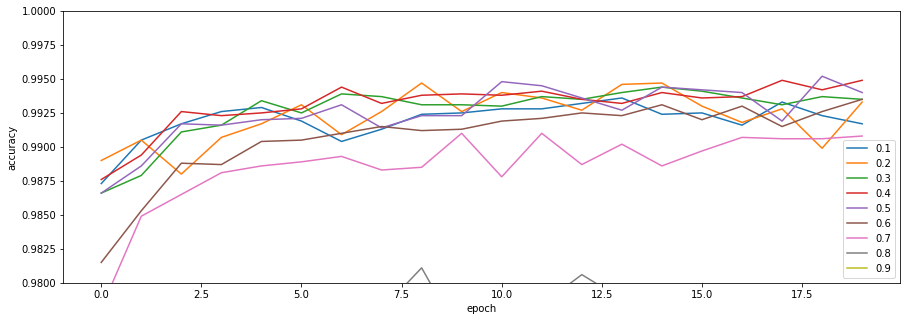

In [ ]:
plt.figure(figsize=(15,5))
for i in range(nets_drop):
  plt.plot(history_drop[i].history["val_accuracy"])

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names_drop)
plt.gca().set_ylim([0.98,1])
plt.show()

The literature suggests to subsample using a convolutional layer with strides 2 instead of a max pooling. Let's try.

In [ ]:
model_CS2 = keras.models.Sequential()
model_CS2.add(keras.layers.Conv2D(filters=32, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
model_CS2.add(keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding="same", activation="relu"))
model_CS2.add(keras.layers.Dropout(0.5))
model_CS2.add(keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"))
model_CS2.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, padding="same", activation="relu"))
model_CS2.add(keras.layers.Dropout(0.5))
model_CS2.add(keras.layers.Flatten())
model_CS2.add(keras.layers.Dense(256, activation='relu'))
model_CS2.add(keras.layers.Dropout(0.5))
model_CS2.add(keras.layers.Dense(10, activation='softmax'))
model_CS2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
model_CS2.fit(train_images, train_labels,
                            epochs=30,
                            validation_data=(test_images, test_labels))

Max validation accuracy: 0.99400


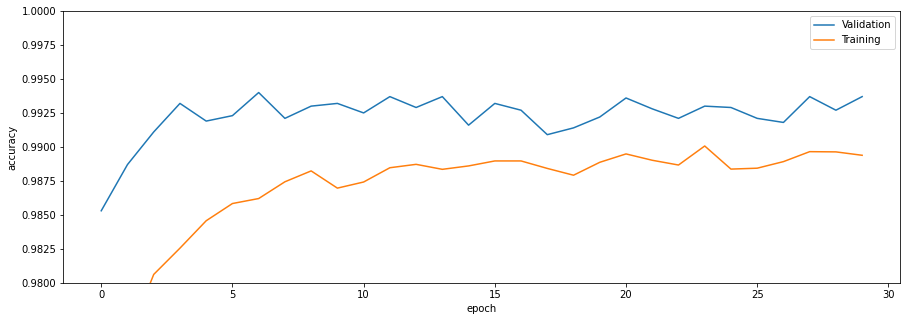

In [ ]:
print(f"Max validation accuracy: {np.max(model_CS2.history.history['val_accuracy']):.5f}")
plt.figure(figsize=(15,5))
plt.plot(model_CS2.history.history["val_accuracy"])
plt.plot(model_CS2.history.history["accuracy"])

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["Validation", "Training"])
plt.gca().set_ylim([0.98,1])
plt.show()

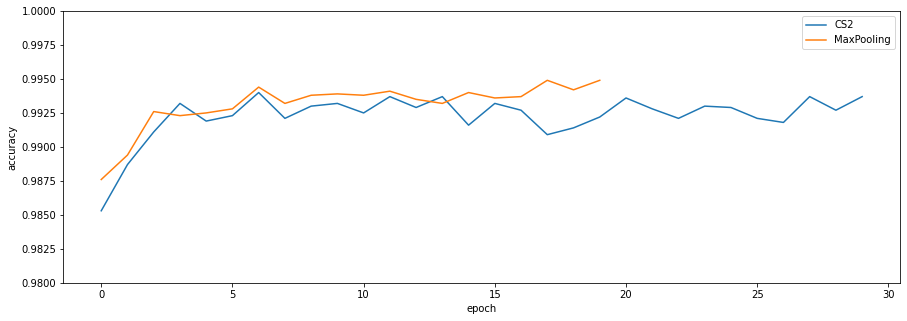

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(model_CS2.history.history["val_accuracy"])
plt.plot(history_drop[3].history["val_accuracy"])

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(["CS2", "MaxPooling"])
plt.gca().set_ylim([0.98,1])
plt.show()

For this particular problem the max pooling performs slightly better.

I will keep the model with CS2 for the last experiment. I will train 100 of them and see what's the average best performace.

In [ ]:
model_best = [0] * 100

In [ ]:
for i in range(100):
  model_best[i] = keras.models.Sequential()
  model_best[i].add(keras.layers.Conv2D(filters=32, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
  model_best[i].add(keras.layers.Conv2D(filters=32, kernel_size=5, strides=2, padding="same", activation="relu"))
  model_best[i].add(keras.layers.Dropout(0.5))
  model_best[i].add(keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"))
  model_best[i].add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=2, padding="same", activation="relu"))
  model_best[i].add(keras.layers.Dropout(0.5))
  model_best[i].add(keras.layers.Flatten())
  model_best[i].add(keras.layers.Dense(256, activation='relu'))
  model_best[i].add(keras.layers.Dropout(0.5))
  model_best[i].add(keras.layers.Dense(10, activation='softmax'))
  model_best[i].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history_best = [0] * 100
epochs_best = 10
best_accuracy = []

In [ ]:
for i in range(100):
  history_best[i] = model_best[i].fit(train_images, train_labels,
                                      epochs=epochs_best,
                                      validation_data=(test_images, test_labels),
                                      verbose=0)
  best_accuracy.append(np.max(history_best[i].history['val_accuracy']))
  print(f"{i} Best accuracy: {np.max(history_best[i].history['val_accuracy'])}")

mu = 0.9939, std = 0.0005


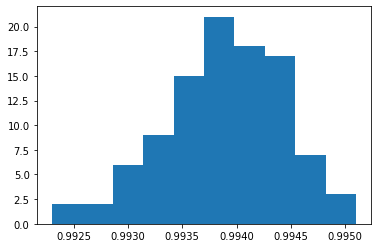

In [ ]:
mu, std = norm.fit(best_accuracy)
print(f"mu = {mu:.4f}, std = {std:.4f}")
plt.hist(best_accuracy, bins=10)
plt.show()

For this problem a deep convolutional network [C-CS2]x2-256-10 with 50% dropout has an average accuracy of 99.39% with a standard deviation of 5e-4.

Let's repeat this with the max pooling.

In [ ]:
model_best_mp = [0] * 100

In [ ]:
for i in range(100):
  model_best_mp[i] = keras.models.Sequential()
  model_best_mp[i].add(keras.layers.Conv2D(filters=32, kernel_size=5, padding="same", activation="relu", input_shape=(28, 28, 1)))
  model_best_mp[i].add(keras.layers.MaxPool2D())
  model_best_mp[i].add(keras.layers.Dropout(0.5))
  model_best_mp[i].add(keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"))
  model_best_mp[i].add(keras.layers.MaxPool2D())
  model_best_mp[i].add(keras.layers.Dropout(0.5))
  model_best_mp[i].add(keras.layers.Flatten())
  model_best_mp[i].add(keras.layers.Dense(256, activation='relu'))
  model_best_mp[i].add(keras.layers.Dropout(0.5))
  model_best_mp[i].add(keras.layers.Dense(10, activation='softmax'))
  model_best_mp[i].compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [ ]:
history_best_mp = [0] * 100
epochs_best_mp = 10
best_accuracy_mp = []

In [ ]:
for i in range(100):
  history_best_mp[i] = model_best_mp[i].fit(train_images, train_labels,
                                            epochs=epochs_best_mp,
                                            validation_data=(test_images, test_labels),
                                            verbose=0)
  best_accuracy_mp.append(np.max(history_best_mp[i].history['val_accuracy']))
  print(f"{i} Best accuracy: {np.max(history_best_mp[i].history['val_accuracy'])}")

mu = 0.9937, std = 0.0004


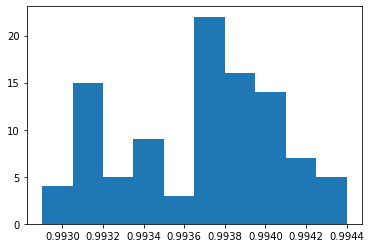

In [ ]:
mu_mp, std_mp = norm.fit(best_accuracy_mp)
print(f"mu = {mu_mp:.4f}, std = {std_mp:.4f}")
plt.hist(best_accuracy_mp, bins=10)
plt.show()

For this problem a deep convolutional network [CP]x2-256-10 with 50% dropout has an average accuracy of 99.37% with a standard deviation of 4e-4.